# Generate YAML for Dataset Generator
The module is to generate leak configuration (yaml document) for dataset_generator.py

## 1.Import Libraries

In [1]:
'''

+-------------------------------+
|                               |
|    I M P O R T   M O D E L    | 
|                               |
+-------------------------------+

Description

Created on Mon Jul  5 18:47:11 2021

@author: gardar
'''

# --------------------------
# Importing public libraries
# --------------------------

# Operating system specific functions
import os

# Argument parser, for configuring the program execution
import argparse

# An object oriented library for handling EPANET files in Python
import epynet 

# yaml / yml configuration file support
import yaml

# PyTorch deep learning framework
import torch

# Import the networkx library
import networkx as nx

# Import Pandas for data handling
import pandas as pd

# Import numpy for array handling
import numpy as np

# Matplotlib for generating graphics
import matplotlib.pyplot as plt

# PyTorch from graph conversion tool
# from torch_geometric.utils import from_networkx

# Train-test split with shuffle 
from sklearn.model_selection import train_test_split

In [2]:
# --------------------------
# Importing custom libraries
# --------------------------

# Import a custom tool for converting EPANET .inp files to networkx graphs
from utils.epanet_loader import get_nx_graph

# Function for visualisationa
from utils.visualisation import visualise

# EPANET simulator, used to generate nodal pressures from the nominal model
from utils.epanet_simulator import epanetSimulator

# SCADA timeseries dataloader
from utils.data_loader import battledimLoader, dataCleaner, dataGenerator

# PyTorch early stopping callback
from utils.early_stopping import EarlyStopping

# Metrics
from utils.metrics import Metrics


## 2.Import INP File

In [3]:
path_to_wdn = '../data/l-town-data/L-TOWN_Real.inp' # Do I need to distinguish between REAL and NOMINAL EPANET inps here? 

In [4]:
# Import the .inp file using the EPYNET library
wdn = epynet.Network(path_to_wdn)

# Solve hydraulic model for a single timestep
wdn.solve()

In [5]:
# Convert the file using a custom function, based on:
# https://github.com/BME-SmartLab/GraphConvWat 
G , pos , head = get_nx_graph(wdn, weight_mode='pipe_length', get_head=True)

In [6]:
neighbours_by_pipe = {}

for node in G:
    for neighbour, connecting_edge in G[node].items():
        if connecting_edge['name'] == 'SELF':
            continue
        else:
            neighbours_by_pipe[connecting_edge['name']] = [node, neighbour]

In [7]:
pipe_by_neighbours = { str(neighbour_list) : pipe for pipe, neighbour_list in neighbours_by_pipe.items()}

In [8]:
neighbours_by_pipe

{'p253': [347, 1],
 'p5': [3, 2],
 'p259': [352, 2],
 'p261': [353, 3],
 'p12': [9, 4],
 'p241': [8, 5],
 'p264': [355, 5],
 'p7': [9, 6],
 'p267': [357, 6],
 'p11': [10, 7],
 'p258': [351, 7],
 'p269': [358, 7],
 'p242': [11, 8],
 'p272': [360, 8],
 'p246': [344, 10],
 'p260': [352, 10],
 'p275': [362, 10],
 'p243': [13, 11],
 'p278': [364, 11],
 'p6': [14, 12],
 'p266': [356, 12],
 'p244': [17, 13],
 'p281': [366, 13],
 'p14': [16, 14],
 'p268': [357, 14],
 'p15': [16, 15],
 'p247': [344, 15],
 'p284': [368, 15],
 'p16': [18, 16],
 'p245': [21, 17],
 'p286': [369, 17],
 'p17': [20, 18],
 'p18': [24, 18],
 'p250': [345, 19],
 'p277': [363, 19],
 'p289': [371, 19],
 'p252': [23, 20],
 'p274': [361, 20],
 'p291': [372, 20],
 'p19': [25, 21],
 'p293': [373, 21],
 'p8': [30, 22],
 'p271': [359, 22],
 'p295': [374, 22],
 'p251': [31, 23],
 'p280': [365, 23],
 'p299': [377, 23],
 'p248': [346, 24],
 'p301': [378, 24],
 'p20': [28, 26],
 'p283': [367, 26],
 'p300': [377, 26],
 'p13': [31, 27

In [9]:
def discoverNeighbourhood(pipe, neighbours_by_pipe, pipe_by_neighbours, graph, k=3):
    
    leaky_nodes = neighbours_by_pipe[pipe]
    
    node_1_neighbours = nx.single_source_shortest_path_length(graph, leaky_nodes[0], cutoff=k)
    node_2_neighbours = nx.single_source_shortest_path_length(graph, leaky_nodes[1], cutoff=k)
    
    n_hop_neighbours = [unique for unique in pd.DataFrame([node_1_neighbours, node_2_neighbours]).columns]

    pipes_in_neighbourhood = []                                                    # List of neighbourhood pipes
    for neighbour1 in n_hop_neighbours:                                            # For neighbour 1 
        for neighbour2 in n_hop_neighbours:                                        # For neighbour 2
            pipe = pipeByneighbourLookup(neighbour1,neighbour2,pipe_by_neighbours) # Look for a connecting pipe ...
            if pipe:                                                               # ... with the neighbours and if found:
                pipes_in_neighbourhood.append(pipe)                                # .... add it to the list
    
    pipes_in_neighbourhood = list(dict(zip(pipes_in_neighbourhood,[pipes_in_neighbourhood.count(i) for i in pipes_in_neighbourhood])).keys())
    
    return pipes_in_neighbourhood, n_hop_neighbours

In [10]:
def pipeByneighbourLookup(node1, node2, pipe_by_neighbours, verbose=False):
    try:
        return pipe_by_neighbours[str([node1,node2])]    # If we don't find the first combination
    except:
        try:                                            # We try the next
            return pipe_by_neighbours[str([node2,node1])]
        except:                                         # And if we still don't find it
            if verbose:
                print('Nodes are not connected by a pipe')
            return None                                 # We return nothing

In [11]:
pipes, _ = discoverNeighbourhood('p419', neighbours_by_pipe, pipe_by_neighbours, G, k=6)

In [12]:
all_pipes = list(pipe_by_neighbours.values())

In [13]:
# p227,p235,p239 not in pipe list, maybe PRVs
for i in range(1,906):
    if 'p'+str(i) not in all_pipes:
        print('p'+str(i))

p227
p235
p239


## 3.Generate Leak Configuration

In [14]:
# Network param
pipe_num = len(pipe_by_neighbours)

# Leak types
leak_time_profile = ['abrupt', 'incipient']
leak_num = 15
sim_step_minutes = 5
one_day_in_step = 24 * 60 / 5
max_dia_list = [0.012, 0.018, 0.024]
rate = [0.2, 0.4, 0.4]

# Set duration in hours
timeStamp = pd.date_range("2018-01-01 00:00", "2018-12-31 23:55", freq=str(sim_step_minutes) + "min")

# Set leak pipes at random
all_pipes_ = []
for i in range(1, pipe_num):
    if i == 227 or i == 235 or i == 239:
        continue
    all_pipes_.append('p'+str(i))
leak_pipe_id = np.random.choice(len(all_pipes_), size=leak_num, replace=False)
leak_pipe = [all_pipes_[_] for _ in leak_pipe_id]

# leak_pipe = ['p123', 'p142', 'p193', 'p257', 'p277', 'p280', 'p331', 'p426', 'p427', 'p455', 'p514', 'p523', 'p586', 'p653', 'p654', 'p680', 'p710', 'p721', 'p762', 'p800', 'p810', 'p827', 'p879']

In [15]:
# Initialization
leak_start = []
leak_end = []
leak_diameter = []
leak_type = []
leak_peak = []

In [16]:
twenty_min = 20 / sim_step_minutes
for i, pipe_id in enumerate(leak_pipe):
    # Find previous leak pipe within detection radius
    cur_neigbours = discoverNeighbourhood(pipe_id, neighbours_by_pipe, pipe_by_neighbours, G, k=6)
    
    # Leak type (abrupt/incipient)
    leak_type.append(leak_time_profile[np.random.randint(2)])
    
    # Leak type (backgroung/medium/large)
    leak_no = np.random.choice(a=np.arange(3), p=rate)
    leak_type_size = max_dia_list[leak_no]
    
    nei_start = []
    nei_end = []
    for j in range(i):
        if leak_pipe[j] in cur_neigbours:
            nei_start.append(leak_start[j])
            nei_end.append(leak_end[j])
    
    if leak_no == 0:
        leak_duration = np.random.randint(low=365*one_day_in_step//2, high=365*one_day_in_step)
    elif leak_no == 1:
        leak_duration = np.random.randint(low=10*one_day_in_step, high=60*one_day_in_step)
    elif leak_no == 2:
        leak_duration = np.random.randint(low=15*one_day_in_step, high=60*one_day_in_step)
    
    if len(nei_start):
        while True:
            cur_leak_start = np.random.randint(low=0, high=len(timeStamp))
            cur_leak_end = min(cur_leak_start + leak_duration, len(timeStamp)-1)
            succeed = True
            for st, ed in enumerate(zip(nei_start, nei_end)):
                if (st > cur_leak_end and st - cur_leak_end >= twenty_min) or (cur_leak_start > ed and cur_leak_start - ed >= twenty_min):
                    continue
                succeed = False
            if succeed:
                break
    else:
        cur_leak_start = np.random.randint(low=0, high=len(timeStamp))
        cur_leak_end = min(cur_leak_start + leak_duration, len(timeStamp)-1)
    
    # Leak start time and end time
    leak_start.append(timeStamp[cur_leak_start])
    leak_end.append(timeStamp[cur_leak_end])
    
    # Leak diameter
    leak_diameter.append(np.random.uniform(leak_type_size-0.004, leak_type_size))
    
    # Leak peak time
    pk = np.random.randint(cur_leak_start + (cur_leak_end-cur_leak_start) // 3, cur_leak_start + (cur_leak_end-cur_leak_start) // 2) if leak_type[i] == 'incipient' else cur_leak_start
    leak_peak.append(timeStamp[pk])

In [17]:
comb_arr = sorted(zip(leak_pipe, leak_start, leak_end, leak_diameter, leak_type, leak_peak), key=lambda x: x[1])

leak_info = {'leakages': []}
for x in comb_arr:
    cur_leak = f'{x[0]}, {x[1]}, {x[2]}, {x[3]:.6f}, {x[4]}, {x[5]}'
    leak_info['leakages'].append(cur_leak)

In [18]:
leak_info['leakages']

['p334, 2018-02-17 07:15:00, 2018-03-17 04:50:00, 0.022773, abrupt, 2018-02-17 07:15:00',
 'p731, 2018-02-21 21:05:00, 2018-04-16 17:10:00, 0.014427, incipient, 2018-03-15 19:15:00',
 'p321, 2018-02-27 07:45:00, 2018-04-26 07:25:00, 0.017228, incipient, 2018-03-27 19:30:00',
 'p862, 2018-04-14 01:00:00, 2018-06-12 14:30:00, 0.017627, abrupt, 2018-04-14 01:00:00',
 'p229, 2018-07-09 16:30:00, 2018-08-04 16:55:00, 0.017495, abrupt, 2018-07-09 16:30:00',
 'p504, 2018-07-17 06:15:00, 2018-09-03 23:00:00, 0.016230, incipient, 2018-08-05 14:15:00',
 'p16, 2018-07-24 13:35:00, 2018-08-10 18:25:00, 0.021691, incipient, 2018-07-30 17:05:00',
 'p489, 2018-08-07 17:05:00, 2018-12-31 23:55:00, 0.009491, abrupt, 2018-08-07 17:05:00',
 'p616, 2018-08-22 17:00:00, 2018-10-02 00:05:00, 0.020126, abrupt, 2018-08-22 17:00:00',
 'p331, 2018-09-01 01:10:00, 2018-09-30 10:50:00, 0.021550, abrupt, 2018-09-01 01:10:00',
 'p315, 2018-09-06 06:50:00, 2018-09-24 12:30:00, 0.020767, abrupt, 2018-09-06 06:50:00',

In [19]:
with open('dataset_configuration.yaml', 'w', encoding='utf-8') as f:
    yaml.dump(leak_info, f, width=float("inf"))

## 4.Draw Leak Positions

In [14]:
print('Importing dataset configuration...\n')

# Open the dataset configuration file
with open('../data/l-town-data/dataset_configuration.yaml') as file:

    # Load the configuration to a dictionary
    config = yaml.load(file, Loader=yaml.FullLoader)

# Generate a list of integers, indicating the number of the node
# at which a  pressure sensor is present
sensors = [int(string.replace("n", "")) for string in config['pressure_sensors']]

Importing dataset configuration...



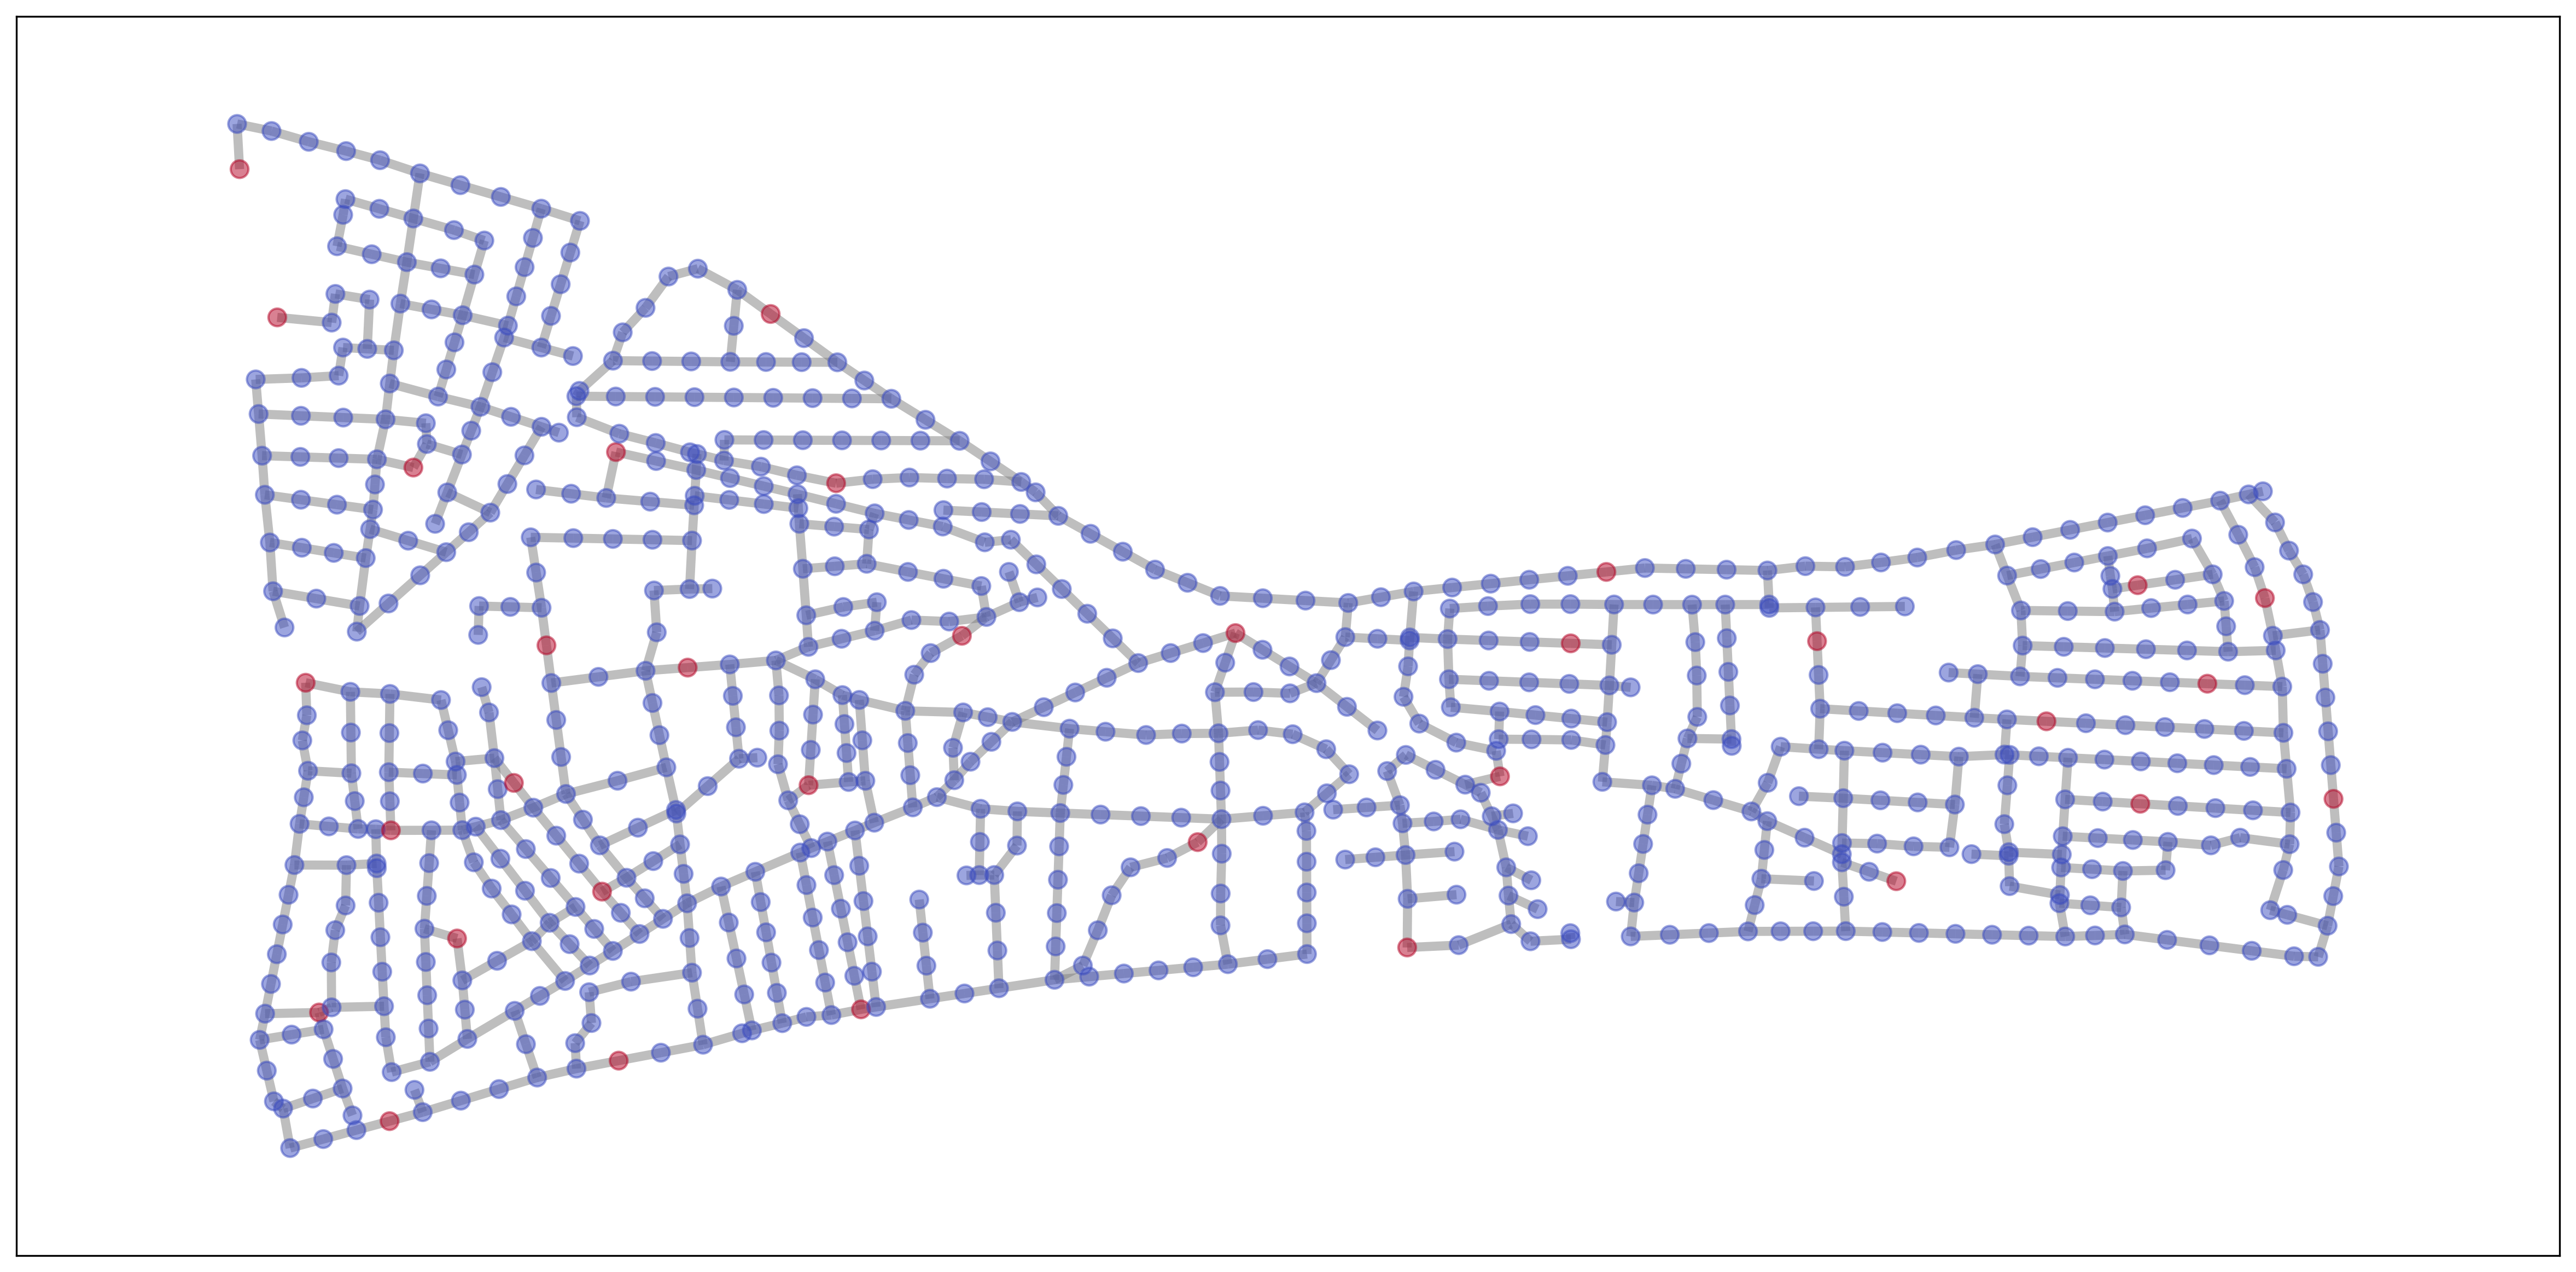

In [15]:
colormap = pd.Series([1.0 if i in sensors else 0.0 for i in range(1,G.number_of_nodes()+1)])

# Generate a colormap
cmap  = plt.get_cmap('coolwarm')

# Fit the datapoints to the colormap
color = cmap(colormap)

# Visualise the the model using our visualisation utility
# axis = visualise(G, pos=pos, color = color, figsize = (20,10), edge_labels=False)

# Visualize leak positions
# leak_pos = list(map(tuple, [neighbours_by_pipe[_] for _ in leak_pipe]))

_, axis = plt.subplots(nrows=1,ncols=1, figsize=(20,10), dpi = 300)

nx.draw_networkx(
    G,
    pos,
    node_size = 60,
    node_color=color,
    with_labels=False,
#     edgelist=leak_pos,
    width=4,
    alpha=0.5,
    edge_color="tab:gray",
)

plt.show()

In [16]:
from matplotlib.colors import LinearSegmentedColormap

# 定义颜色映射的色彩列表，格式为 (位置, (R, G, B))
colors = [(0, 'black'), (1, 'red')]

# 创建自定义的 colormap
cmap = LinearSegmentedColormap.from_list('custom_colormap', colors)

color = cmap(colormap)

In [17]:
node_info = [
    ('R1', (2760.32, 1079.74)),
    ('R2', (444.86, 806.31)),
    ('T1', (573.35, 1142.78))
]

for name, p in node_info:
    G.add_node(name, pos=p)
    pos[name] = p
    
# 添加已存在的边信息
edges_info = [(54, 'T1')]

# 添加边
G.add_edges_from(edges_info)

In [18]:
# 设置中文和 LaTeX 字体
plt.rcParams['font.sans-serif'] = ['simsun']

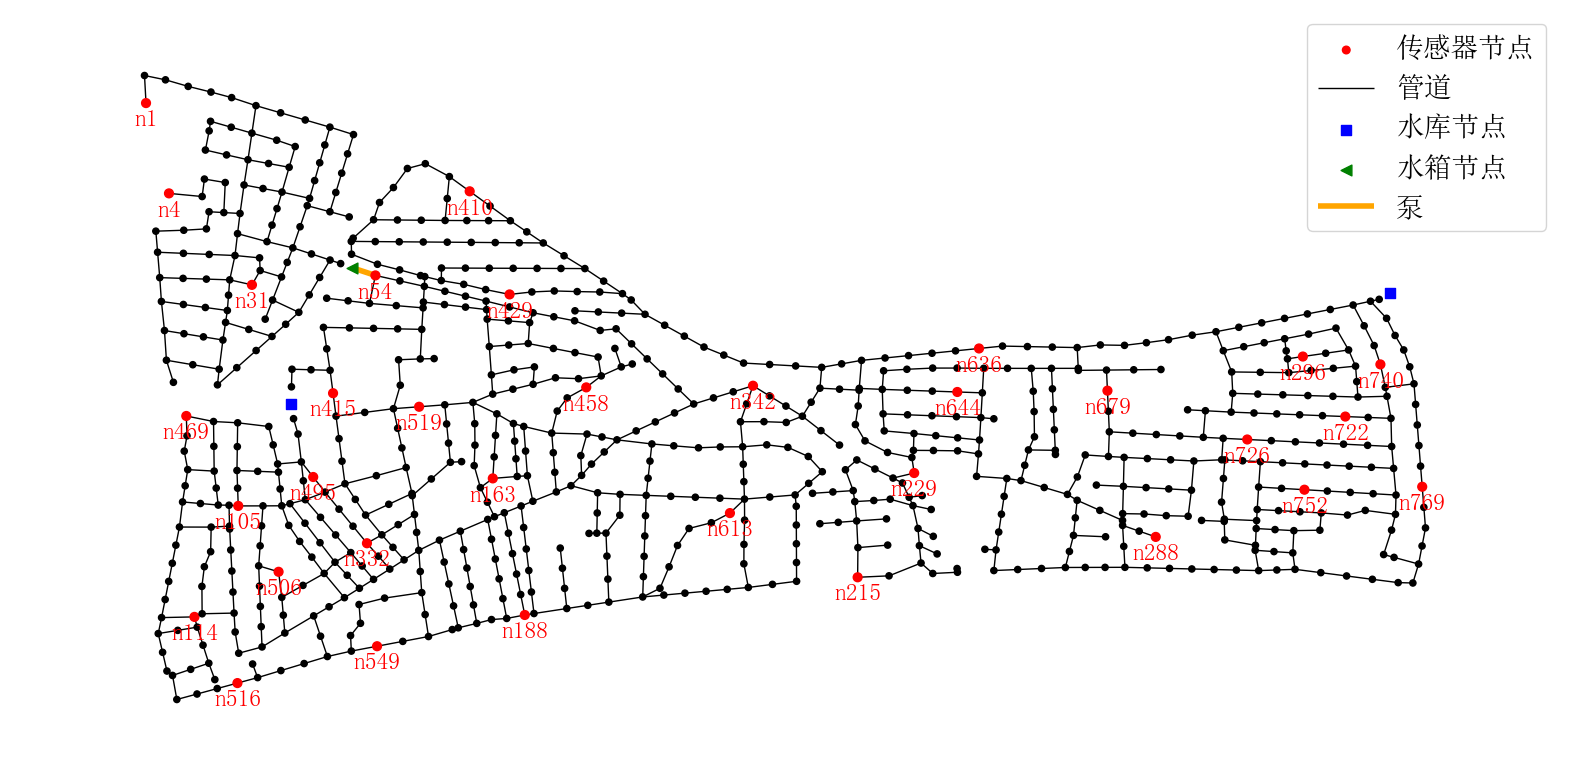

In [19]:
_, axis = plt.subplots(figsize=(20,10), dpi = 100)
axis.set_axis_off()

nx.draw_networkx(G, pos=pos, arrows = G.is_directed(),
                 nodelist=[node for node in G.nodes() if node not in [name for name, _ in node_info]],
                         with_labels=False, node_size=[40 if x == 1 else 20 for x in colormap],
                         font_size = 7,font_color = 'w',
                         node_color=color, ax=axis)
# nx.draw_networkx(G, pos=pos, arrows = G.is_directed(),
#                          with_labels=False, node_size=20,
#                          font_size = 7,font_color = 'w',
#                          node_color='black', ax=axis)

# nx.draw_networkx_nodes(G, pos, nodelist=sensors, node_shape='o', node_color='red', node_size=40)

# 绘制特殊节点
nx.draw_networkx_nodes(G, pos, nodelist=['R1','R2'], node_shape='s', node_color='blue', node_size=60)
nx.draw_networkx_nodes(G, pos, nodelist=['T1'], node_shape='<', node_color='green', node_size=60)

nx.draw_networkx_edges(G, pos, edgelist=edges_info, width=4.0, edge_color='orange')

labels = {node: f'n{node}' if node in sensors else '' for node in G.nodes()}
label_pos = {node: (pos[node][0], pos[node][1] - 40) for node in G.nodes()}
nx.draw_networkx_labels(G, label_pos, labels, font_size=17, font_color='red')

plt.legend(['传感器节点', '管道','水库节点','水箱节点','泵'], loc='upper right', fontsize=20)

# 显示图形
plt.show()

In [20]:
with open('config.yaml', 'r') as file:
    subarea_config = yaml.load(file, Loader=yaml.FullLoader)

In [21]:
zone_node_dict = {}
for key in subarea_config.keys():
    if 'zone' in key:
        zone_node_dict[key] = [int(_[1:]) for _ in subarea_config[key]]

In [22]:
custom_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

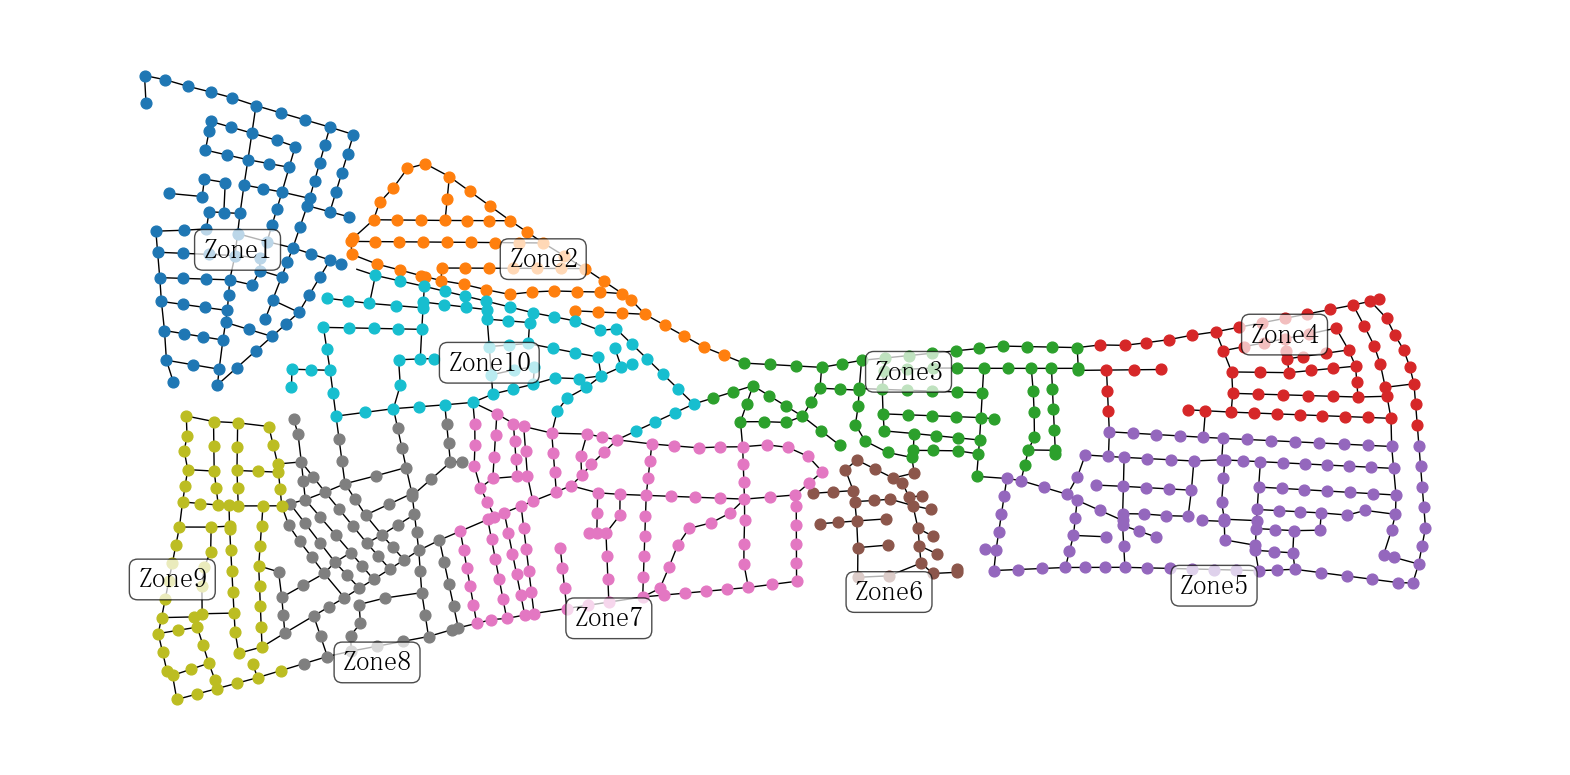

In [28]:
_, axis = plt.subplots(figsize=(20,10), dpi = 100)
axis.set_axis_off()

nx.draw_networkx(G, pos=pos, arrows = G.is_directed(),
                         with_labels=False, node_size=20,
                         font_size = 7,font_color = 'w',
                         node_color='white', ax=axis)

i = 0
for key in zone_node_dict.keys():
    nx.draw_networkx_nodes(G, pos, nodelist=zone_node_dict[key], node_shape='o', node_color=custom_colors[i], node_size=60)
    i += 1
    
label_nodes = [18,75,633,694,716,217,197,549,479,76]
label_pos = {node: (pos[node][0], pos[node][1] - 40) for node in label_nodes}
# text = ['分区1', '分区2', '分区3', '分区4', '分区5', '分区6', '分区7', '分区8', '分区9', '分区10']
text = ['Zone1', 'Zone2', 'Zone3', 'Zone4', 'Zone5', 'Zone6', 'Zone7', 'Zone8', 'Zone9', 'Zone10']
labels = {node: text for node, text in zip(label_nodes,text)}
nx.draw_networkx_labels(G, label_pos, labels, font_size=20, font_weight='black',font_color='black',font_family='sans-serif',bbox=dict(alpha=0.7,facecolor='white', edgecolor='black',boxstyle='round'))

# nx.draw_networkx_nodes(G, pos, nodelist=sensors, node_shape='o', node_color='red', node_size=40)

# 绘制特殊节点
# nx.draw_networkx_nodes(G, pos, nodelist=['R1','R2'], node_shape='s', node_color='blue', node_size=60)
# nx.draw_networkx_nodes(G, pos, nodelist=['T1'], node_shape='<', node_color='green', node_size=60)

# nx.draw_networkx_edges(G, pos, edgelist=edges_info, width=4.0, edge_color='orange')

# labels = {node: f'n{node}' if node in sensors else '' for node in G.nodes()}
# label_pos = {node: (pos[node][0], pos[node][1] - 40) for node in G.nodes()}
# nx.draw_networkx_labels(G, label_pos, labels, font_size=17, font_color='red')

# plt.legend(['传感器节点', '管道','水库节点','水箱节点','泵'], loc='upper right', fontsize=20)

# 显示图形
plt.show()

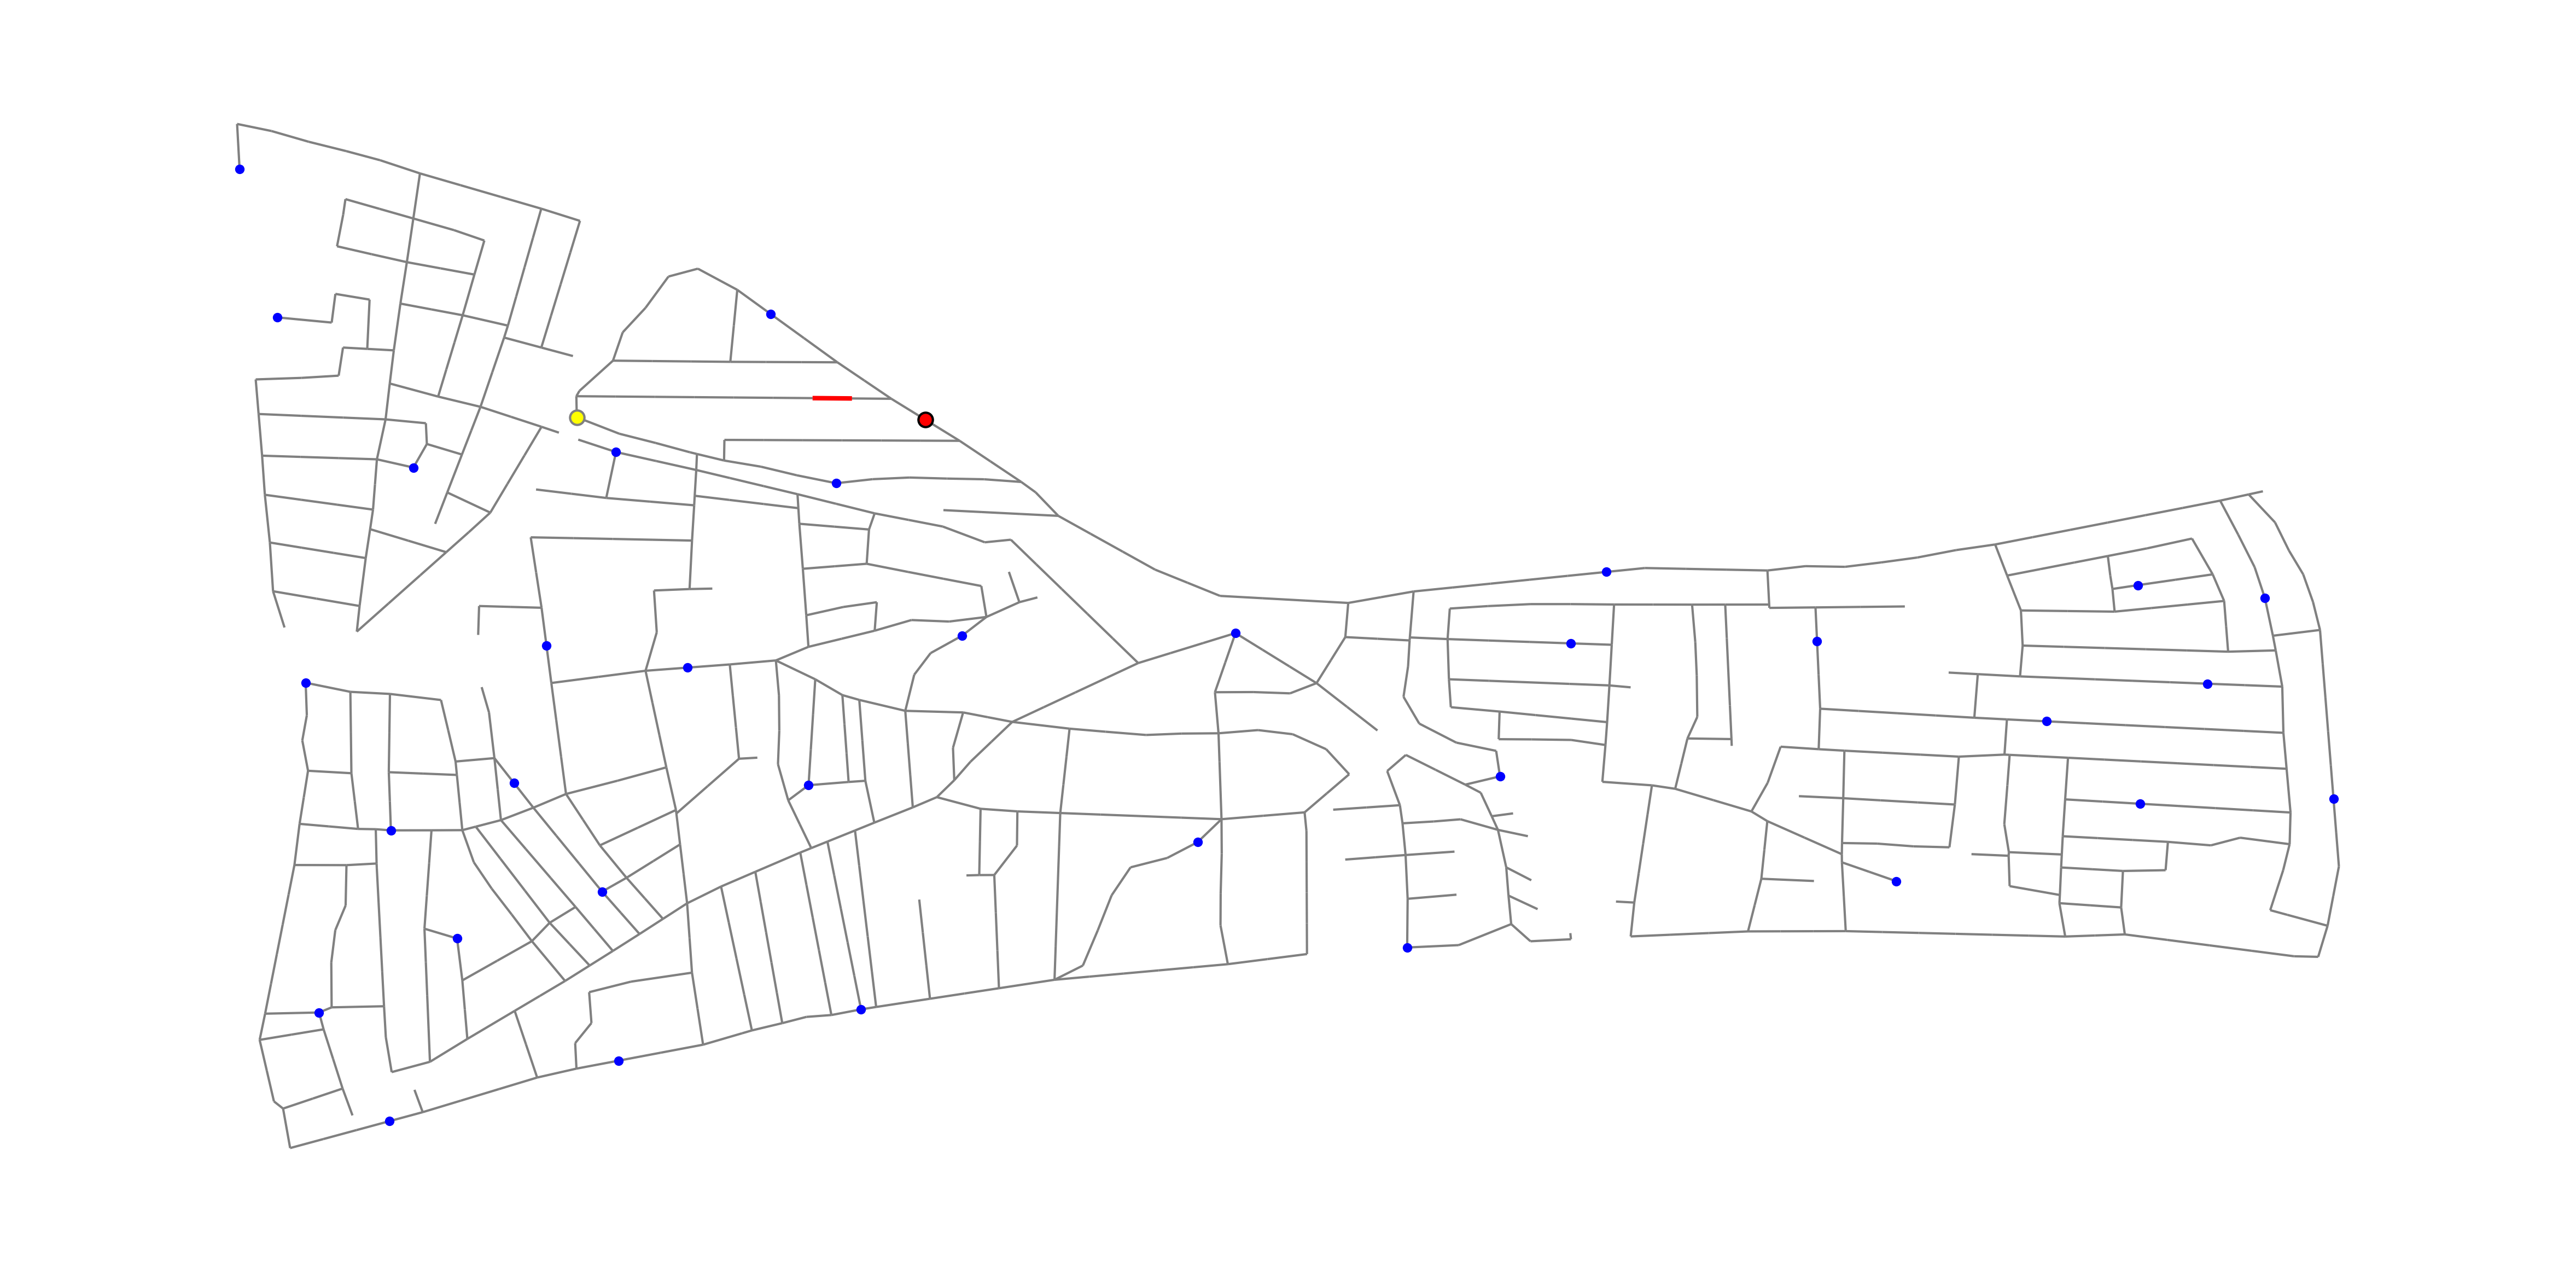

In [24]:
zone_name = 'zone4'

_, axis = plt.subplots(figsize=(20,10), dpi = 300)
axis.set_axis_off()

subarea_pos = {node: pos[node] for node in zone_node_dict[zone_name]}
H = G.subgraph(zone_node_dict[zone_name])

nx.draw_networkx(G, pos=pos, arrows = G.is_directed(),
                         with_labels=False, node_size=0,edge_color = 'gray',width=1,
                         font_size = 7,font_color = 'w',
                         node_color='black', ax=axis)

nx.draw_networkx_nodes(G, pos, nodelist=sensors, node_shape='o', node_color='blue', node_size=10)
nx.draw_networkx_edges(G, pos, edgelist=[(398, 399)], width=2.0, edge_color='red')
nx.draw_networkx_nodes(G, pos, nodelist=[390], node_shape='o', node_color='yellow', linewidths=1,edgecolors='gray', node_size=40)
nx.draw_networkx_nodes(G, pos, nodelist=[438], node_shape='o', node_color='red',linewidths=1,edgecolors='black', node_size=40)

plt.show()

In [25]:
leak_info = ['p123',
    'p280',
 'p277',
 'p331',
 'p426',
 'p710',
 'p721',
 'p800',
 'p879',
 'p827',
 'p193',
 'p762',
 'p680',
 'p653',
 'p142',
 'p523',
 'p514',
 'p586',
 'p455']

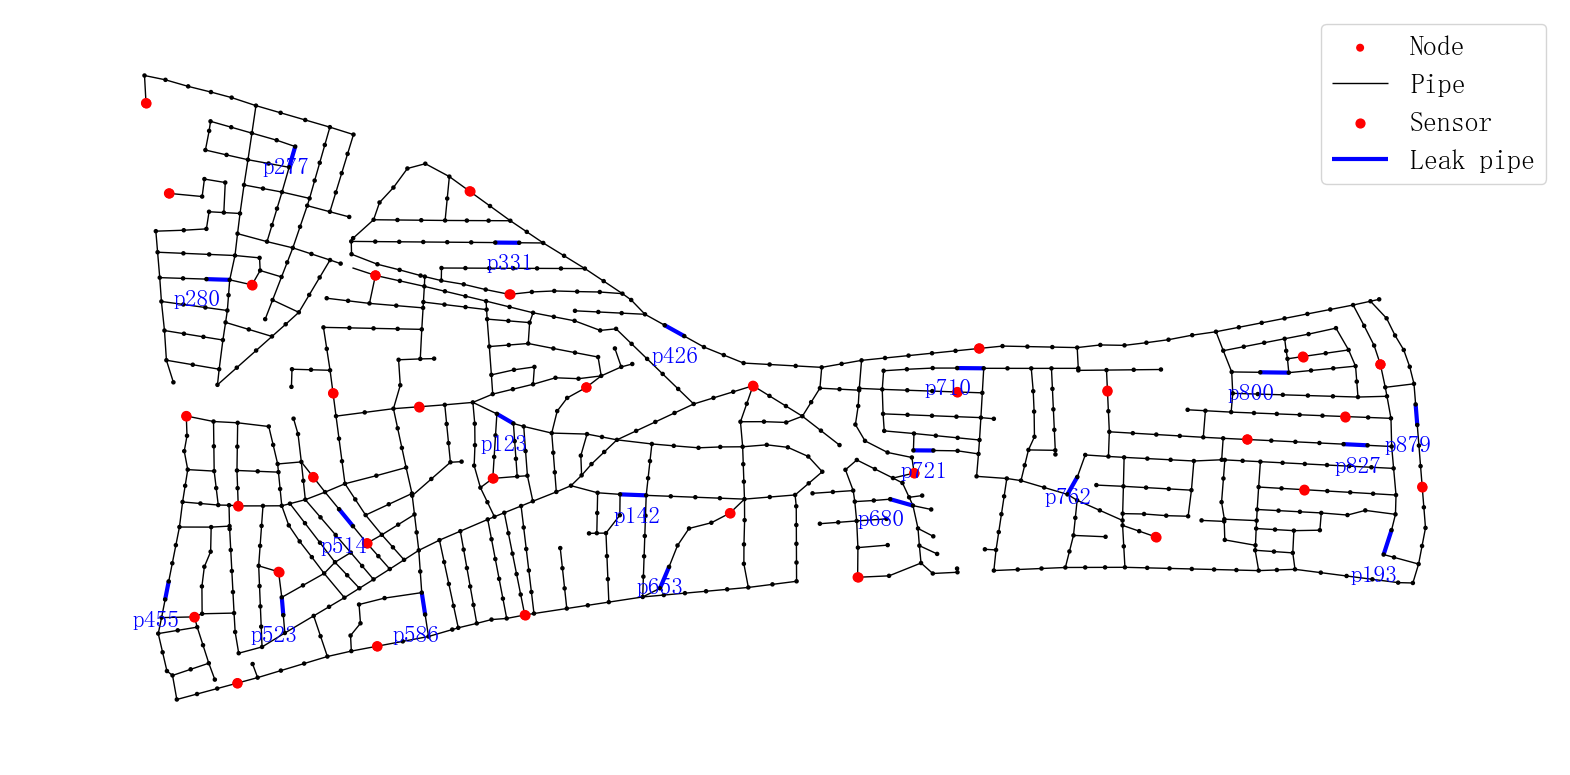

In [29]:
_, axis = plt.subplots(figsize=(20,10), dpi = 100)
axis.set_axis_off()

nx.draw_networkx(G, pos=pos, arrows = G.is_directed(),
                 nodelist=[node for node in G.nodes() if node not in [name for name, _ in node_info]],
                         with_labels=False, node_size=[40 if x == 1 else 5 for x in colormap],
                         font_size = 7,font_color = 'w',
                         node_color=color, ax=axis)
# nx.draw_networkx(G, pos=pos, arrows = G.is_directed(),
#                          with_labels=False, node_size=10,
#                          font_size = 7,font_color = 'w',
#                          node_color='gray', ax=axis)

nx.draw_networkx_nodes(G, pos, nodelist=sensors, node_shape='o', node_color='red', node_size=40)


labels = {neighbours_by_pipe[pipe][0]: f'{pipe}' for pipe in leak_info}
label_pos = {neighbours_by_pipe[pipe][0]: (pos[neighbours_by_pipe[pipe][0]][0]-20, pos[neighbours_by_pipe[pipe][0]][1] - 50) for pipe in leak_info}
nx.draw_networkx_labels(G, label_pos, labels, font_size=17, font_color='blue')
leak_edgelist = [tuple(neighbours_by_pipe[_]) for _ in leak_info]
nx.draw_networkx_edges(G, pos, edgelist=leak_edgelist, width=3.0, edge_color='blue')

# plt.legend(['节点', '管道','传感器节点','泄漏管道','泵'], loc='upper right', fontsize=20)
plt.legend(['Node', 'Pipe','Sensor','Leak pipe','Pump'], loc='upper right', fontsize=20)

# 显示图形
plt.show()

In [27]:
tuple(neighbours_by_pipe['p653'])

(609, 608)